Mając już dane zabieram się za implementacji vq-vae dla naszego zbioru

In [49]:
import torch.optim as optim
import numpy as np
from tqdm.notebook import trange, tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch
from PIL import Image
import io
from datasets import load_from_disk
import utils as utl
import torch.nn.functional as F

# Wczytanie i przetworzenie

## wczytanie

In [50]:
dataset = load_from_disk('Datasets/minecraft_dataset_vectors')
ds = dataset.to_pandas()
ds

,image,is_block,type,colors
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
3,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
...,...,...,...,...
1513,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1514,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1515,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1516,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [51]:
ds.shape

(1518, 4)

## przetworzenie

In [52]:
mask = []
for index, row in ds.iterrows():
    img = Image.open(io.BytesIO(row['image']['bytes']))
    mask.append((img.width == 16) & (img.height == 16))

ds = ds[mask]
ds

,image,is_block,type,colors
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
3,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
...,...,...,...,...
1513,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1514,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1515,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1516,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [53]:
ds.shape

(1499, 4)

## dataloader

In [54]:
class MinecraftDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.transform = Compose([
            ToTensor()
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # get image
        img_bytes = self.dataframe.iloc[idx]['image']['bytes']
        img = Image.open(io.BytesIO(img_bytes)).convert("RGBA")
        img_tensor = self.transform(img)
        img_tensor = (img_tensor - 0.5) / 0.5 # normalization instead of transform from vq-vae-try
        # get other columns
        is_block = self.dataframe.iloc[idx]['is_block']
        type_ = self.dataframe.iloc[idx]['type']
        colors = self.dataframe.iloc[idx]['colors']

        return img_tensor, is_block, type_, colors

In [55]:
# parameters
batch_size = 16
lr = 1e-4

use_cuda = torch.cuda.is_available()
gpu_indx  = 0
device = torch.device(gpu_indx if use_cuda else "cpu")
use_cuda

False

In [56]:
dataset = MinecraftDataset(ds)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0) # i've setup num_of_workers to 0 for now because i've got  AttributeError: Can't get attribute 'MinecraftDataset' on <module '__main__' (built-in)>. In collab i will set this parameter to 4

In [57]:
len(train_dataset)

1199

In [58]:
len(test_dataset)

300

# Trening
Wczytam sobie klasę sieci i inne potrzebne rzeczy z pliku utils.py

In [59]:
# Get a test image
dataiter = iter(test_loader)
test_images = next(dataiter)[0]

print(test_images.shape) # batch size, number of columns, img_x, img_y

torch.Size([16, 4, 16, 16])


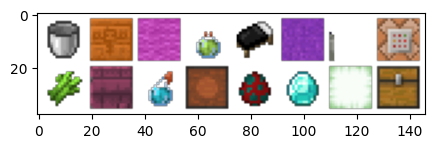

In [60]:
plt.figure(figsize = (5,5))
out = vutils.make_grid(test_images, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [61]:
# The number of code book embeddings
code_book_size = 512

# The number of latent embedding channels
latent_channels = 128

# Number of Training epochs
vq_nepoch = 50

# Create our network
vae_net = utl.VQVAE(channel_in=test_images.shape[1], latent_channels=latent_channels, ch=64,
                code_book_size=code_book_size, commitment_cost=0.25).to(device)

# Setup optimizer
optimizer = optim.Adam(vae_net.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda')

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=vq_nepoch, eta_min=0)

# Create loss logger
recon_loss_log = []
qv_loss_log = []
test_recon_loss_log = []
train_loss = 0

C:\Users\jakub\Documents\GitHub\minecraft-pixel-art-generator\.venv\lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [62]:
num_model_params = 0
for param in vae_net.parameters():
    num_model_params += param.flatten().shape[0]

print("-The VQVAE Model Has %d (Approximately %d Million) Parameters!" % (num_model_params,
                                                                          num_model_params//1e6))

-The VQVAE Model Has 10701252 (Approximately 10 Million) Parameters!


In [63]:
recon_data, vq_loss, quantized = vae_net(test_images.to(device))

# View the Latent vector shape
quantized.shape

torch.Size([16, 128, 4, 4])

In [64]:
# training start
pbar = trange(0, vq_nepoch, leave=False, desc="Epoch")
for epoch in pbar:
    pbar.set_postfix_str('Loss: %.4f' % (train_loss/len(train_loader)))
    train_loss = 0
    vae_net.train()
    for i, data in enumerate(tqdm(train_loader, leave=False, desc="Training")):

        image = data[0].to(device)
        with torch.amp.autocast('cuda'):
            # Forward pass the image in the data tuple
            recon_data, vq_loss, quantized = vae_net(image)

            # Calculate the loss
            recon_loss = F.l1_loss(recon_data, image)
            loss = vq_loss + recon_loss

        # Take a training step
        optimizer.zero_grad()
        if(device == "cuda"):
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        # Log the loss
        recon_loss_log.append(recon_loss.item())
        qv_loss_log.append(vq_loss.item())
        train_loss += recon_loss.item()

    lr_scheduler.step()

    vae_net.eval()
    for i, data in enumerate(tqdm(test_loader, leave=False, desc="Testing")):
        image = data[0].to(device)
        with torch.amp.autocast('cuda'):
            with torch.no_grad():
                # Forward pass the image in the data tuple
                recon_data, vq_loss, quantized = vae_net(image)

                # Calculate the loss
                recon_loss = (recon_data - image).pow(2).mean()
                loss = vq_loss + recon_loss
                test_recon_loss_log.append(recon_loss.item())

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

C:\Users\jakub\Documents\GitHub\minecraft-pixel-art-generator\.venv\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

## Sprawdzenie metryk po treningu

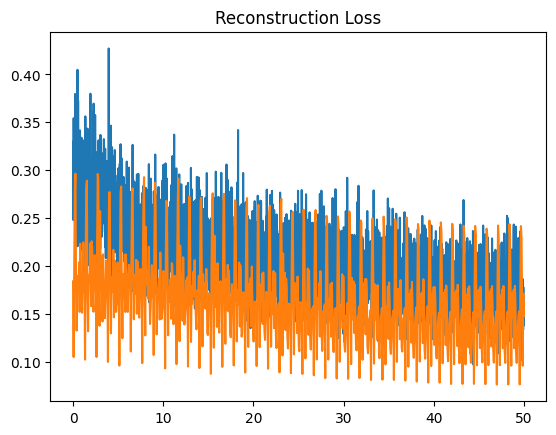

In [65]:
# Results
x_train = np.linspace(0, vq_nepoch, len(recon_loss_log[200:]))
_ = plt.plot(x_train, recon_loss_log[200:])

x_test = np.linspace(0, vq_nepoch, len(test_recon_loss_log[200:]))
_ = plt.plot(x_test, test_recon_loss_log[200:])
_ = plt.title("Reconstruction Loss")

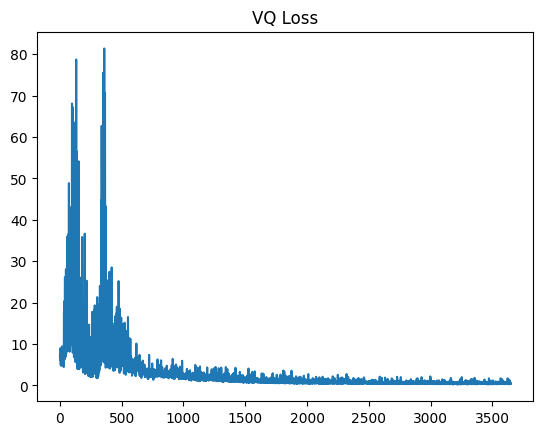

In [66]:
_ = plt.plot(qv_loss_log[100:])
_ = plt.title("VQ Loss")

In [67]:
vae_net.eval()
recon_data, vq_loss, quantized = vae_net(test_images.to(device))

In [68]:
vq_loss, quantized, encoding_indices = vae_net.encode(test_images.to(device))

In [69]:
encoding_indices[0]

tensor([153, 492, 492, 153, 153, 492, 180, 196, 153, 180, 180, 180, 153, 315,
        180, 196])

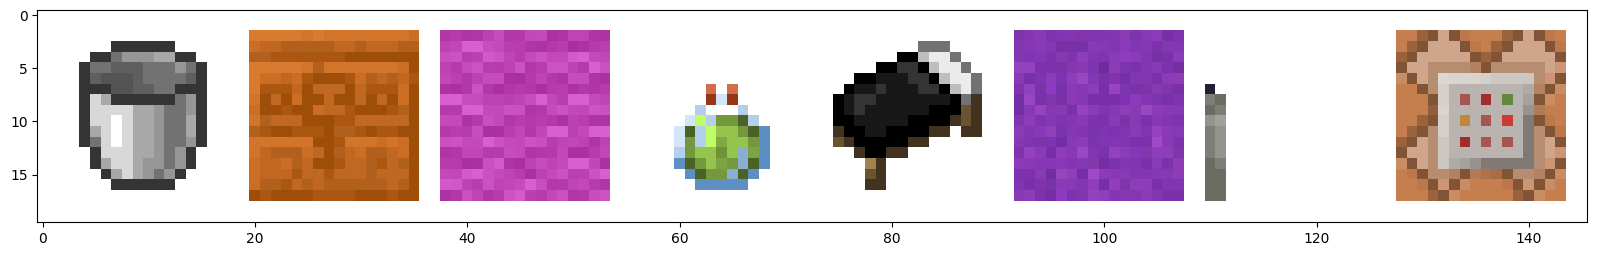

In [70]:
# ground truth
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

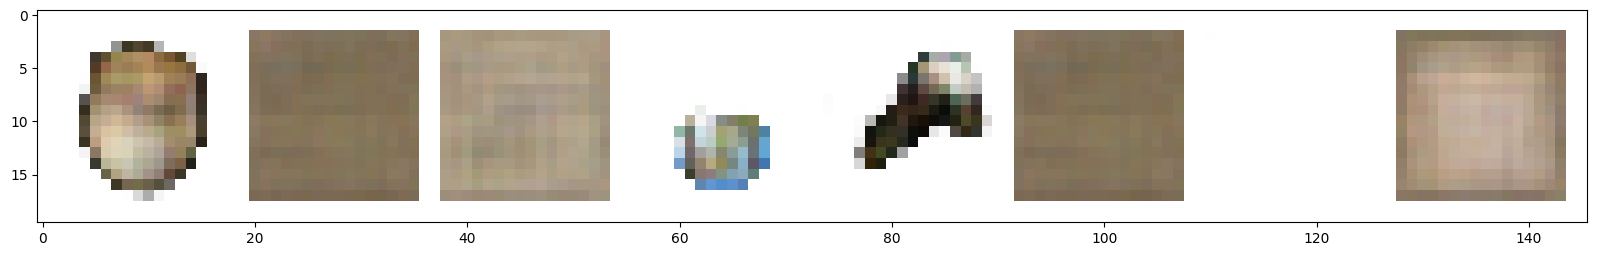

In [71]:
# reconstruction
plt.figure(figsize = (20,10))
out = vutils.make_grid(recon_data.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))